In [4]:
import pandas as pd

data = pd.read_csv('../ssd_data/lstm_data/final_data_MA1.csv',index_col=False)

# 데이터를 시간 순서대로 정렬 ('ds' 컬럼을 기준으로)
data = data.sort_values(by=['ds'])
data = data.drop_duplicates(subset=['disk_id', 'ds'])
data.reset_index(inplace=True)
del(data['index'])
data

,disk_id,ds,r_1,n_5,r_5,r_9,r_12,n_171,r_171,n_172,...,r_194,r_195,n_196,r_196,r_197,r_198,r_199,n_175,r_175,label
0,28267,2019-01-01,4.294967e+09,95.0,0.0,46339.0,41.0,100.0,0.0,100.0,...,14.0,2.202509e+08,100.0,0.0,0.0,0.0,0.0,100.0,1.159917e+12,0
1,1674,2019-01-01,4.294967e+09,96.0,0.0,9021.0,-1.0,-1.0,-1.0,-1.0,...,14.0,-1.000000e+00,100.0,0.0,-1.0,-1.0,-1.0,100.0,2.323887e+11,0
2,3160,2019-01-01,4.294967e+09,98.0,0.0,40273.0,29.0,100.0,0.0,100.0,...,13.0,1.100210e+06,100.0,0.0,0.0,0.0,0.0,100.0,1.027004e+12,0
3,11918,2019-01-01,4.294967e+09,97.0,0.0,38090.0,-1.0,-1.0,-1.0,-1.0,...,12.0,-1.000000e+00,100.0,0.0,-1.0,-1.0,-1.0,100.0,9.582576e+11,0
4,12036,2019-01-01,4.294967e+09,97.0,1.0,38317.0,-1.0,-1.0,-1.0,-1.0,...,19.0,-1.000000e+00,99.0,1.0,-1.0,-1.0,-1.0,100.0,9.664309e+11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75164,1664,2019-06-30,4.294967e+09,97.0,0.0,23299.0,-1.0,-1.0,-1.0,-1.0,...,15.0,-1.000000e+00,100.0,0.0,-1.0,-1.0,-1.0,100.0,5.970077e+11,0
75165,10533,2019-06-30,4.294967e+09,94.0,0.0,50860.0,33.0,100.0,0.0,100.0,...,15.0,1.333815e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.288904e+12,0
75166,13332,2019-06-30,4.294967e+09,97.0,0.0,42594.0,-1.0,-1.0,-1.0,-1.0,...,15.0,-1.000000e+00,100.0,0.0,-1.0,-1.0,-1.0,100.0,1.082661e+12,0
75167,6924,2019-06-30,4.294967e+09,94.0,0.0,50024.0,43.0,100.0,0.0,100.0,...,15.0,8.036993e+08,100.0,0.0,0.0,0.0,0.0,100.0,1.258629e+12,0


In [5]:
# 70% 지점의 인덱스를 찾아 훈련 및 테스트 데이터로 분할
index_70_percent = int(len(data) * 0.7)
cutoff_date = data.iloc[index_70_percent]['ds']

data = data.sort_values(by=['ds'])

# cutoff_date 이전의 데이터는 train_data로, 이후 데이터는 test_data로 분할
train_data = data[data['ds'] <= cutoff_date]
train_data['ds']=pd.to_datetime(train_data['ds'])

test_data = data[data['ds'] > cutoff_date]
test_data['ds']=pd.to_datetime(test_data['ds'])

X_train = train_data.drop(['label'],axis=1)
y_train = train_data[['disk_id', 'ds', 'label']]
X_test = test_data.drop(['ds','label'],axis=1)
y_test = test_data[['disk_id','ds','label']]

C:\Users\choib\AppData\Local\Temp\ipykernel_31460\1291999633.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['ds']=pd.to_datetime(train_data['ds'])
C:\Users\choib\AppData\Local\Temp\ipykernel_31460\1291999633.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ds']=pd.to_datetime(test_data['ds'])


In [6]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(28, 256, batch_first=True)
        self.fc1 = nn.Linear(256, 128)
        #self.relu = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (x, _) = self.lstm1(x)
        x = self.fc1(x.squeeze(1))
        #x = self.relu(x)
        #x = self.dropout1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# 모델 인스턴스 생성
lstm_model = LSTMModel()


In [8]:
filled_data = pd.DataFrame()

unique_ids = data['disk_id'].unique()

for disk_id in unique_ids:
    disk_data = data[data['disk_id'] == disk_id].copy()
    # disk_data를 날짜별로 정렬
    disk_data['ds'] = pd.to_datetime(disk_data['ds'])
    disk_data = disk_data.sort_values(by='ds')

    # 인덱스를 날짜로 설정
    disk_data = disk_data.set_index('ds', drop=True)

    # 비어있는 날짜를 ffill 방법으로 채우기
    all_dates = pd.date_range(start=disk_data.index.min(), end=disk_data.index.max(), freq='D')
    # disk_data = disk_data.reindex(all_dates, method='linear')
    disk_data = disk_data.reindex(all_dates)
    disk_data.interpolate(method='linear')
    filled_data=pd.concat([filled_data,disk_data])

In [22]:
filled_data = pd.DataFrame()
unique_ids = data['disk_id'].unique()

for disk_id in unique_ids:
    disk_data = data[data['disk_id'] == disk_id].copy()
    disk_data['ds'] = pd.to_datetime(disk_data['ds'])
    disk_data = disk_data.sort_values(by='ds')
    disk_data = disk_data.set_index('ds', drop=True)
    all_dates = pd.date_range(start=disk_data.index.min(), end=disk_data.index.max(), freq='D')
    disk_data = disk_data.reindex(all_dates)
    disk_data = disk_data.interpolate(method='linear')
    filled_data = filled_data.append(disk_data)

filled_data = filled_data.reset_index()  # 인덱스 재설정

C:\Users\choib\AppData\Local\Temp\ipykernel_31460\661459830.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filled_data = filled_data.append(disk_data)
C:\Users\choib\AppData\Local\Temp\ipykernel_31460\661459830.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filled_data = filled_data.append(disk_data)
C:\Users\choib\AppData\Local\Temp\ipykernel_31460\661459830.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filled_data = filled_data.append(disk_data)
C:\Users\choib\AppData\Local\Temp\ipykernel_31460\661459830.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filled_data = filled_data.append(disk_data)
C:\Users\choib\A

In [23]:
filled_data[filled_data['disk_id']==28267.0]

,index,disk_id,r_1,n_5,r_5,r_9,r_12,n_171,r_171,n_172,...,r_194,r_195,n_196,r_196,r_197,r_198,r_199,n_175,r_175,label
0,2019-01-01,28267.0,4.294967e+09,95.0,0.0,46339.0,41.0,100.0,0.0,100.0,...,14.0,220250874.0,100.0,0.0,0.0,0.0,0.0,100.0,1.159917e+12,0.0
1,2019-01-02,28267.0,4.294967e+09,95.0,0.0,46363.0,41.0,100.0,0.0,100.0,...,15.0,220259327.0,100.0,0.0,0.0,0.0,0.0,100.0,1.160011e+12,0.0
2,2019-01-03,28267.0,4.294967e+09,95.0,0.0,46387.0,41.0,100.0,0.0,100.0,...,14.0,220267845.0,100.0,0.0,0.0,0.0,0.0,100.0,1.160105e+12,0.0
3,2019-01-04,28267.0,4.294967e+09,95.0,0.0,46410.0,41.0,100.0,0.0,100.0,...,15.0,220276091.0,100.0,0.0,0.0,0.0,0.0,100.0,1.160199e+12,0.0
4,2019-01-05,28267.0,4.294967e+09,95.0,0.0,46434.0,41.0,100.0,0.0,100.0,...,15.0,220284244.0,100.0,0.0,0.0,0.0,0.0,100.0,1.160293e+12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2019-06-26,28267.0,4.294967e+09,95.0,0.0,50542.0,41.0,100.0,0.0,100.0,...,17.0,220932896.0,100.0,0.0,0.0,0.0,0.0,1.0,1.267304e+12,0.0
177,2019-06-27,28267.0,4.294967e+09,95.0,0.0,50566.0,41.0,100.0,0.0,100.0,...,17.0,220934557.0,100.0,0.0,0.0,0.0,0.0,1.0,1.267398e+12,0.0
178,2019-06-28,28267.0,4.294967e+09,95.0,0.0,50590.0,41.0,100.0,0.0,100.0,...,17.0,220936102.0,100.0,0.0,0.0,0.0,0.0,1.0,1.267492e+12,0.0
179,2019-06-29,28267.0,4.294967e+09,95.0,0.0,50614.0,41.0,100.0,0.0,100.0,...,16.0,220938172.0,100.0,0.0,0.0,0.0,0.0,1.0,1.267586e+12,0.0


In [24]:
filled_data[filled_data['label']==1]

,index,disk_id,r_1,n_5,r_5,r_9,r_12,n_171,r_171,n_172,...,r_194,r_195,n_196,r_196,r_197,r_198,r_199,n_175,r_175,label
83,2019-03-25,28267.0,4.294967e+09,95.0,0.0,48321.0,41.0,100.0,0.0,100.0,...,24.0,2.205981e+08,100.0,0.0,0.0,0.0,0.0,1.0,1.211324e+12,1.0
565,2019-01-02,3401.0,4.294967e+09,98.0,0.0,40012.0,59.0,100.0,0.0,100.0,...,16.0,2.260676e+09,100.0,0.0,0.0,0.0,0.0,100.0,1.005077e+12,1.0
1410,2019-01-17,12242.0,4.294967e+09,93.0,1.0,46860.0,63.0,100.0,0.0,100.0,...,16.0,3.291330e+07,99.0,1.0,0.0,0.0,2.0,100.0,1.181759e+12,1.0
1624,2019-02-19,23472.0,4.294967e+09,98.0,0.0,41782.0,33.0,100.0,0.0,100.0,...,15.0,2.038805e+06,100.0,0.0,0.0,0.0,0.0,1.0,1.065312e+12,1.0
1953,2019-01-17,27017.0,4.294967e+09,94.0,0.0,46752.0,37.0,100.0,0.0,100.0,...,14.0,1.006697e+09,100.0,0.0,0.0,0.0,0.0,1.0,1.177277e+12,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86590,2019-01-27,2329.0,3.551641e+09,97.0,0.0,40557.0,33.0,100.0,0.0,100.0,...,15.0,4.867720e+05,100.0,0.0,0.0,0.0,0.0,100.0,1.022339e+12,1.0
87056,2019-01-29,2802.0,3.553202e+09,98.0,0.0,40602.0,36.0,100.0,0.0,100.0,...,14.0,2.884183e+06,100.0,0.0,0.0,0.0,0.0,100.0,1.018231e+12,1.0
87308,2019-05-09,520.0,4.294967e+09,96.0,0.0,40556.0,27.0,100.0,0.0,100.0,...,16.0,3.373655e+07,100.0,0.0,0.0,0.0,0.0,1.0,1.039495e+12,1.0
88239,2019-02-22,19037.0,1.229500e+04,97.0,1.0,46469.0,27.0,100.0,0.0,100.0,...,21.0,5.767790e+05,99.0,1.0,0.0,0.0,0.0,100.0,1.181709e+12,1.0


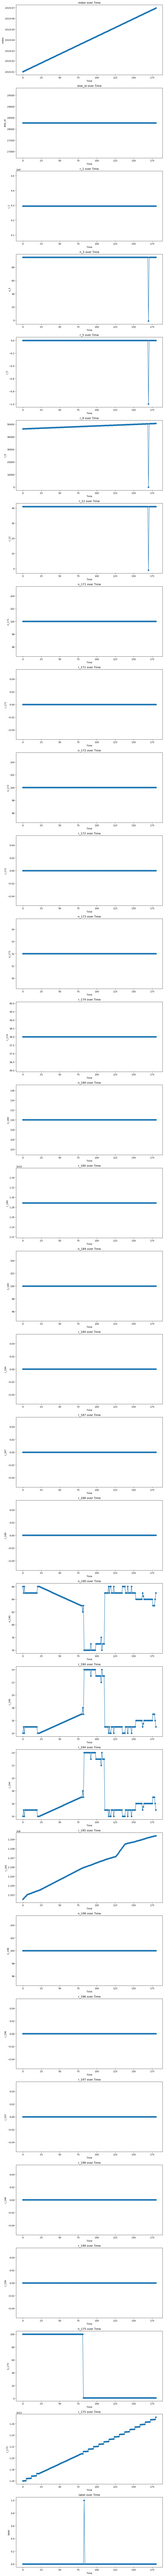

In [25]:
import matplotlib.pyplot as plt

# 특정 disk_id 선택
disk_id = 28267.0
selected_data = filled_data[filled_data['disk_id'] == disk_id]

# 변수들의 플롯
fig, axes = plt.subplots(nrows=len(selected_data.columns), figsize=(10, 5 * len(selected_data.columns)))
for i, column in enumerate(selected_data.columns):
    ax = axes[i]
    ax.plot(selected_data[column],marker='o')
    ax.set_xlabel('Time')
    ax.set_ylabel(column)
    ax.set_title(f'{column} over Time')
plt.tight_layout()
plt.show()

In [11]:
filled_data.to_csv('../ssd_data/lstm_data/filled_data.csv',index=False)

In [191]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, filled_data):
        self.filled_data = filled_data
        self.disk_ids = filled_data['disk_id'].unique()
        
        # 각 disk_id별로 데이터를 미리 준비
        self.samples = []
        self.labels = []
        for disk_id in self.disk_ids:
            disk_data = filled_data[filled_data['disk_id'] == disk_id]
            
            # 5일 윈도우로 데이터 나누기
            for i in range(len(disk_data) - 4):
                sequence = disk_data.iloc[i:i+5].drop(columns=['disk_id', 'label']).values
                label = disk_data.iloc[i + 4]['label']
                self.samples.append(sequence)
                self.labels.append(label)
                
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        return torch.tensor(self.samples[index], dtype=torch.float32), torch.tensor(self.labels[index], dtype=torch.float32)

# 사용 예시:
# filled_data 라는 데이터프레임이 있다고 가정
# filled_data = pd.read_csv('path_to_your_filled_data.csv')

# CustomDataset 인스턴스 생성
dataset = CustomDataset(filled_data)

# 인덱스를 사용하여 데이터 얻기
input_data, label = dataset[0]

In [194]:
from torch.utils.data import DataLoader
# 데이터로더 설정
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [212]:
import torch
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 손실 함수와 최적화 알고리즘 설정
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

# 훈련 설정
num_epochs = 10

# 훈련 루프
for epoch in range(num_epochs):
    total_loss = 0.0

    for inputs, targets in dataloader:
        # 입력 데이터와 타겟 데이터를 GPU로 이동
        inputs = inputs.to(device)
        targets = targets.to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순방향 전파
        outputs = lstm_model(inputs)

        # LSTM 모델의 출력 크기를 target과 일치시키기 위해 필요한 부분만 사용
        # 마지막 시간 단계의 출력만 사용합니다.
        outputs = outputs.squeeze()

        # 손실 계산
        loss = criterion(outputs, targets.float())

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()

        # 손실 누적
        total_loss += loss.item()

    # 에폭마다 손실 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}")

# 훈련 종료 후 모델 저장
torch.save(lstm_model.state_dict(), 'lstm_model.pth')

Epoch 1/10, Loss: 1322.6326724682003
Epoch 2/10, Loss: 1315.6132441684604
Epoch 3/10, Loss: 1308.8682391792536
Epoch 4/10, Loss: 1305.7503788545728
Epoch 5/10, Loss: 1303.5874509438872
Epoch 6/10, Loss: 1301.6289799585938
Epoch 7/10, Loss: 1300.449726190418
Epoch 8/10, Loss: 1299.4021066389978
Epoch 9/10, Loss: 1299.5530086755753
Epoch 10/10, Loss: 1299.221768911928


In [218]:
import torch
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 손실 함수와 최적화 알고리즘 설정
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

# 훈련 설정
num_epochs = 5

# 훈련 루프
for epoch in range(num_epochs):
    total_loss = 0.0

    for inputs, targets in dataloader:
        # 입력 데이터와 타겟 데이터를 GPU로 이동
        inputs = inputs.to(device)
        targets = targets.to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순방향 전파
        outputs = lstm_model(inputs)

        # LSTM 모델의 출력 크기를 target과 일치시키기 위해 필요한 부분만 사용
        # 마지막 시간 단계의 출력만 사용합니다.
        outputs = outputs.squeeze()

        # 손실 계산
        loss = criterion(outputs, targets.float())

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()

        # 손실 누적
        total_loss += loss.item()

    # 에폭마다 손실 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}")

# 훈련 종료 후 모델 저장
torch.save(lstm_model.state_dict(), 'lstm_model.pth')

Epoch 1/5, Loss: 1315.841678140685
Epoch 2/5, Loss: 1308.2197451852262
Epoch 3/5, Loss: 1306.8757094796747
Epoch 4/5, Loss: 1306.212860705331
Epoch 5/5, Loss: 1305.1067350618541


In [220]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터로더 설정
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 손실 함수와 최적화 알고리즘 설정
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

# 훈련 설정
num_epochs = 2

# 훈련 루프
for epoch in range(num_epochs):
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, targets in dataloader:
        # 입력 데이터와 타겟 데이터를 GPU로 이동
        inputs = inputs.to(device)
        targets = targets.to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순방향 전파
        outputs = lstm_model(inputs)
        outputs = outputs.squeeze()

        # 손실 계산
        loss = criterion(outputs, targets.float())

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()

        # 손실 누적
        total_loss += loss.item()

        # 정확도 계산
        predictions = (outputs > 0.5).float()
        correct_predictions += (predictions == targets).float().sum().item()
        total_predictions += targets.size(0)

    # 에폭마다 손실과 정확도 출력
    accuracy = 100 * correct_predictions / total_predictions
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}, Accuracy: {accuracy:.2f}%")

# 훈련 종료 후 모델 저장
torch.save(lstm_model.state_dict(), 'lstm_model.pth')


Epoch 1/2, Loss: 1305.448618490249, Accuracy: 93.48%
Epoch 2/2, Loss: 1304.8488254901022, Accuracy: 93.48%


## Tensorflow

In [1]:
import numpy as np
def create_sequences(data, window_size):
    X = []
    y = []

    # 각 disk_id에 대해 처리
    for disk_id in data['disk_id'].unique():
        disk_data = data[data['disk_id'] == disk_id].sort_values('ds')  # ds로 정렬
        disk_values = disk_data.drop(columns=['disk_id', 'ds']).values  # 'disk_id'와 'ds' 컬럼을 제외하고 numpy array로 변환

        # 이 disk_id에 대해 시퀀스 생성
        for i in range(len(disk_values) - window_size):
            X.append(disk_values[i:i + window_size, :-1])  # 마지막 차원은 특성(feature)을 의미합니다. 마지막 열('fail')을 제외합니다.
            y.append(disk_values[i + window_size, -1])  # 예를 들어 'fail' 상태가 마지막 특성일 경우입니다.

    return np.array(X), np.array(y)

In [6]:
# 70% 지점의 인덱스를 찾아 훈련 및 테스트 데이터로 분할
index_70_percent = int(len(data) * 0.7)
cutoff_date = data.iloc[index_70_percent]['ds']

# cutoff_date 이전의 데이터는 train_data로, 이후 데이터는 test_data로 분할
train_data = data[data['ds'] <= cutoff_date]
test_data = data[data['ds'] > cutoff_date]


X_train = train_data.drop(['disk_id','ds','label'],axis=1)
y_train = train_data['label']
X_test = test_data.drop(['disk_id','ds','label'],axis=1)
y_test = test_data['label']
X_train

,r_1,n_5,r_5,r_9,r_12,n_171,r_171,n_172,r_172,n_173,...,r_190,r_194,r_195,n_196,r_196,r_197,r_198,r_199,n_175,r_175
0,4.294967e+09,95.0,0.0,46339.0,41.0,100.0,0.0,100.0,0.0,52.0,...,14.0,14.0,220250874.0,100.0,0.0,0.0,0.0,0.0,100.0,1.159917e+12
1,4.294967e+09,96.0,0.0,9021.0,-1.0,-1.0,-1.0,-1.0,-1.0,47.0,...,-1.0,14.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,100.0,2.323887e+11
2,4.294967e+09,98.0,0.0,40273.0,29.0,100.0,0.0,100.0,0.0,97.0,...,13.0,13.0,1100210.0,100.0,0.0,0.0,0.0,0.0,100.0,1.027004e+12
3,4.294967e+09,97.0,0.0,38090.0,-1.0,-1.0,-1.0,-1.0,-1.0,97.0,...,-1.0,12.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,100.0,9.582576e+11
4,4.294967e+09,97.0,1.0,38317.0,-1.0,-1.0,-1.0,-1.0,-1.0,17.0,...,-1.0,19.0,-1.0,99.0,1.0,-1.0,-1.0,-1.0,100.0,9.664309e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52681,4.294967e+09,96.0,0.0,40673.0,-1.0,-1.0,-1.0,-1.0,-1.0,70.0,...,-1.0,14.0,-1.0,100.0,0.0,-1.0,-1.0,-1.0,100.0,1.027116e+12
52682,4.294967e+09,98.0,2.0,43092.0,28.0,100.0,2.0,100.0,0.0,1.0,...,20.0,20.0,297294512.0,99.0,2.0,0.0,0.0,0.0,100.0,1.095782e+12
52683,4.294967e+09,92.0,0.0,48777.0,25.0,100.0,0.0,100.0,0.0,85.0,...,16.0,16.0,223080006.0,100.0,0.0,0.0,0.0,0.0,100.0,1.241408e+12
52684,4.294967e+09,96.0,0.0,43904.0,29.0,100.0,0.0,100.0,0.0,68.0,...,19.0,19.0,929475655.0,100.0,0.0,0.0,0.0,0.0,100.0,1.112414e+12


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [8]:
# Assuming 'X_train' is the original DataFrame before scaling and its columns are to be preserved
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

train_scaled = pd.concat([train_data[['disk_id','ds']],X_train_scaled_df, y_train], axis=1)
test_scaled = pd.concat([test_data[['disk_id','ds']],X_test_scaled_df, y_test], axis=1)

In [9]:
window_size = 3 # 10일을 window로 설정합니다.
X_train_window, y_trian_window = create_sequences(train_scaled, window_size)
X_test_window, y_test_window = create_sequences(test_scaled, window_size)

In [1]:
# 라이브러리 임포트
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import regularizers

# LSTM 모델 정의
model = Sequential()
model.add(LSTM(16, activation='relu', input_shape=(3, 28)))  # n_features는 특성의 수
model.add(Dense(16, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])

# 학습
history = model.fit(X_train_window,y_trian_window,epochs=4, verbose=0,batch_size=32)

NameError: name 'X_train_window' is not defined

In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                2880      
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,169
Trainable params: 3,169
Non-trainable params: 0
_________________________________________________________________


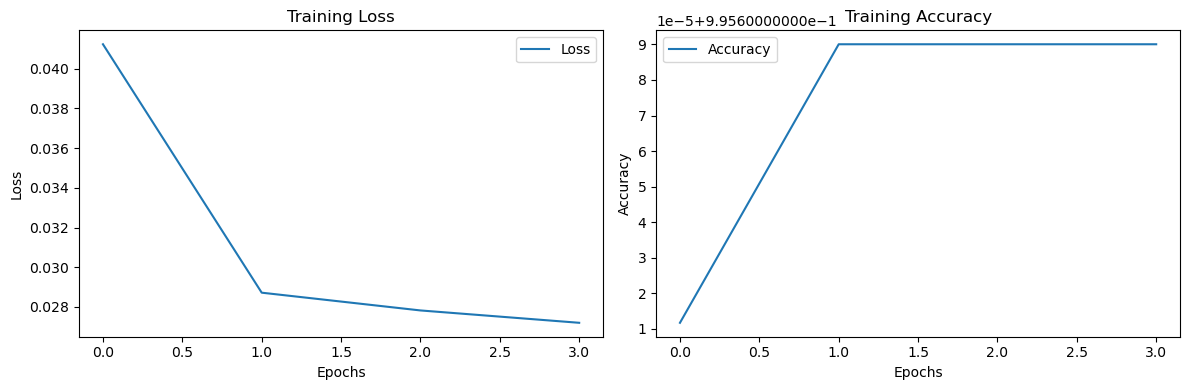

In [11]:
import matplotlib.pyplot as plt

# 훈련 손실과 정확도 그리기
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['acc'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
model.evaluate(X_test_window,y_test_window)

659/659 [==============================] - 1s 1ms/step - loss: 0.0139 - acc: 0.9984


[0.013941628858447075, 0.998432993888855]

In [13]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.
y_pred = np.round(y_pred) # 이진 분류 문제의 경우, 출력값을 반올림하여 0 또는 1로 변환

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'F1 Score: {f1}')

659/659 [==============================] - 1s 940us/step
F1 Score: 0.4996079363193537


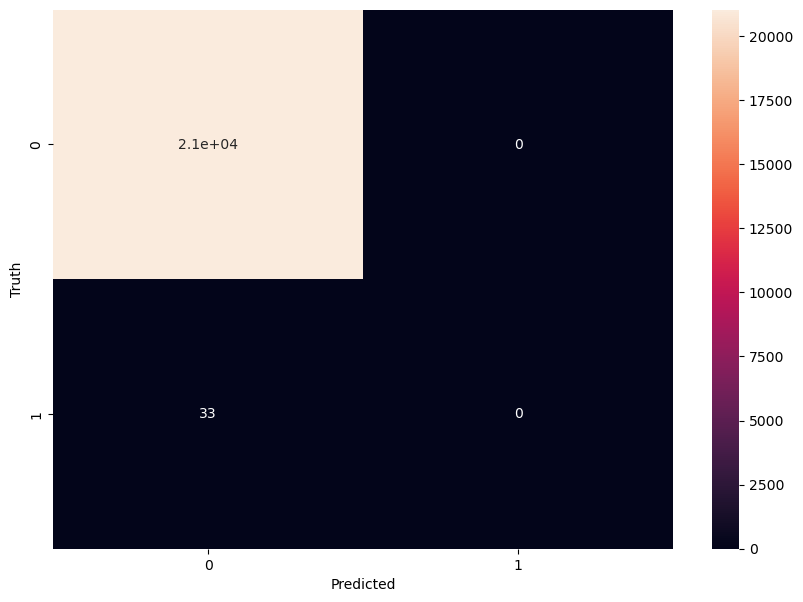

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## Conv 1D + LSTM

- Conv 1D 를 통해, 30일의 feature extraction(FE)
- FE된 feature map들의 시계열성 특징을 LSTM을 통해 추출
- 마지막 Fully Connected layer를 통해, Classification 진행(healthy / fail)

In [27]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [33]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None,30, 28)))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1, activation='sigmoid'))
model_cnn_lstm.compile(loss='binary_crossentropy', optimizer='adam')

In [55]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout

# TensorFlow eager execution 설정
tf.config.run_functions_eagerly(True)

# 예시로서 X_train 데이터 생성
# X_train 데이터의 형태: (batch_size, 6, 30, 28)
batch_size = 100
seq_length = 6
timesteps = 30
num_features = 28

# 임의의 데이터로 예시를 보여주기 위해 랜덤한 값을 사용
X_train = np.random.randn(batch_size, seq_length, timesteps, num_features)
y_train = np.random.randint(0, 2, size=(batch_size, 1))

# 모델 정의
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=32, kernel_size=5, activation='relu'), input_shape=(None,30, 28)))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu')))
# model_cnn_lstm.add(TimeDistributed(Dropout(0.5)))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(64, activation='relu'))
model_cnn_lstm.add(Dense(64, activation='relu'))
# model_cnn_lstm.add(Dropout(0.5))
model_cnn_lstm.add(Dense(1, activation='sigmoid'))
# 모델 컴파일
model_cnn_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# TensorFlow eager execution 재설정
tf.config.run_functions_eagerly(False)

# 학습
history = model_cnn_lstm.fit(X_train, y_train, epochs=5, verbose=0, batch_size=32)

In [56]:
# 임의의 데이터로 예시를 보여주기 위해 랜덤한 값을 사용
X_test = np.random.randn(batch_size, seq_length, timesteps, num_features)
y_test = np.random.randint(0, 2, size=(batch_size, 1))

In [57]:
predicted=model_cnn_lstm.predict(X_test)

4/4 [==============================] - 0s 8ms/step


In [58]:
y_hat = np.array([])  # 빈 배열로 초기화

for i in range(len(X_test)):
    # 예측 결과를 기반으로 y_hat에 원소를 추가
    if model_cnn_lstm.predict(X_test[i:i+1]) > 0.5:
        y_hat = np.concatenate((y_hat, np.array([1])), axis=0)
    else:
        y_hat = np.concatenate((y_hat, np.array([0])), axis=0)

1/1 [==============================] - 0s 23ms/step


In [59]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_hat)

0.5

In [32]:
import numpy as np

# 예시로서 X_train 데이터 생성
# X_train 데이터의 형태: (batch_size, 6, 30, 28)
batch_size = 100
seq_length = 6
timesteps = 30
num_features = 28

# 임의의 데이터로 예시를 보여주기 위해 랜덤한 값을 사용
X_train = np.random.randn(batch_size, seq_length, timesteps, num_features)
y_train = np.rando
# 모델에 X_train 데이터를 입력으로 사용하여 예측 등의 작업을 수행
model_cnn_lstm.fit(X_train)

ValueError: in user code:

    File "c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\keras\engine\training.py", line 1052, in train_step
        self._validate_target_and_loss(y, loss)
    File "c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\keras\engine\training.py", line 1006, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=mse, and therefore expects target data to be provided in `fit()`.
